In [1]:
import pandas as pd
import numpy as np
import re
from umap import UMAP
from math import log
import os
from tqdm import tqdm
from stop_words import get_stop_words
stop_words = get_stop_words('ru')
from pymystem3 import Mystem
from collections import defaultdict
import artm
import math
import top2vec
from top2vec import Top2Vec
from scipy.spatial import distance
%matplotlib inline
import glob
import gensim
from sklearn.mixture import GaussianMixture
import logging
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer
import matplotlib.pyplot as plt
from statistics import median, variance
import pickle
import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\vdtri\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\vdtri\anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:172: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


# Functions

In [2]:
pattern = re.compile("[а-яА-ЯёЁ]+")
m = Mystem()
model_path = r'C:\Users\vdtri\Documents\ВКР\Программа\models\\'
path_to_prog = r'C:\Users\vdtri\Documents\ВКР\Программа\\'

def stemming(text, m):
    lemmas = m.lemmatize(text)
    return ''.join(lemmas)

def sem_close_ARTM(model_artm):
    sem = list()
    for topic_name in model_artm.topic_names:
#         print(topic_name + ': ')
        temp = model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]
        sum_ = 0
        for ind, word1 in enumerate(temp):
            for word2 in temp:
                try:
                    sum_ += distance.cosine(w2v[word1], w2v[word2])
                except:
                    sum_ +=1.0
        sem.append(sum_/len(temp))
#    return sum(sem)/len(sem)
    return sem

def doc2vow(text):
    text = text.split(sep='.')
    temp_block = list()
    for pred in text:
        temp_block.append(' '.join(re.findall(pattern, pred)))
    text = temp_block   
    text = stemming(' . '.join(text), m).split(sep = '.')
    
    vow = str()
    defdict = defaultdict(int)
    new_text = str()
    for word in''.join(text).replace('\n', '').split():
        if len(word)>2 and word not in stop_words:
            defdict[word] += 1
    vow += 'doc' + ' '
    for key, elem in defdict.items():
        vow += key + ':' + str(elem) + ' '
    vow += '\n'
    with open('vow_test.txt', 'w+', encoding='utf-8') as file:
        file.write(vow)
    batch_vectorizer_test = artm.BatchVectorizer(data_path='vow_test.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='batch_test')
    return batch_vectorizer_test

def get_theta(model, batch):
    return model.transform(batch_vectorizer=batch)

def bestTopics(vector, topics):
    new_vec = list()
    for ind, item in enumerate(topics):
        new_vec.append(vector[topics[ind]])
    return new_vec

def sem_close_Top2vec(model):
    sem = list()
    for i in range(model.get_num_topics()):
        temp = model.topic_words[i][:6]
        sum_ = 0
        for ind, word1 in enumerate(temp):
            for word2 in temp:
                try:
                    sum_ += distance.cosine(navec[word1], navec[word2])
                except:
                    sum_ +=0.7
        sem.append(sum_/len(temp))
#    return sum(sem)/len(sem)
    return sem

def topic_probs(doc, topic_vecs, k):
    results = list()
    ind = 0
    for i in topic_vecs:
        results.append(1/(distance.euclidean(doc, i) ** k))
    return np.array(results)/sum(results)

# def dist_top10(item, items_list):
#     res = list()
#     for i in tqdm(items_list):
#         res.append(distance.cosine(item, list(i)))
#     return sorted(zip(range(len(items_list)), res), key = lambda x: x[1])

def dist_top10(item, items_list):
    res = list()
    for i in items_list:
        res.append(distance.cosine(item, i))
    return sorted(zip(range(len(res)), res), key = lambda x: x[1])[1:11]

def prec(pred, k, num):
    s = 0
    for i in range(k):
        if pred[i] < num + 11 and pred[i]>num:
            s += 1
    return s/k

def clean_data(text):
    text = text.split(sep='.')
    temp_block = list()
    for pred in text:
        temp_block.append(' '.join(re.findall(pattern, pred)))
    text = temp_block   
    text = stemming(' . '.join(text), m).split(sep = '.')
    new_text = str()
    for word in ''.join(text).replace('\n', '').split():
        if len(word)>2 and word not in stop_words:
            new_text += word + ' '
    return new_text

def create_dict(texts):
    list_of_dicts = list()
    dict_ = defaultdict(int)
    for text in tqdm(texts):
        list_of_dicts.append(defaultdict(int))
        for word in text.split():
            list_of_dicts[-1][word] += 1
            dict_[word] += 1
    return (list_of_dicts, dict_)

# Preprocessing

In [4]:
os.chdir(r'C:\Users\vdtri\Documents\ВКР\Программа\wiki_18k')

texts = list()
path = r'C:\Users\vdtri\Documents\ВКР\Программа\wiki_18k'
for file in tqdm(os.listdir(path)):
    with open(file, 'r', encoding='utf-8') as file_handler:
        texts.append(file_handler.read())
texts = list(set(texts))

In [5]:
os.chdir(r'C:\Users\vdtri\Documents\ВКР\Программа')
habr = pd.read_csv("habr_posts.csv")
habr = list(habr['text'].values)
habr_texts = list()
for i in tqdm(habr):
    try:
        if len(i.split())>500:
            habr_texts.append(i)
    except:
        pass
habr_texts = list(set(habr_texts))
len(habr_texts)

In [6]:
all_texts = list()
all_texts = texts + habr_texts
print(len(all_texts))

In [7]:
for i, item in enumerate(all_texts):
    all_texts[i] = all_texts[i].split(sep='.')
for i in tqdm(range(len(all_texts))):
    temp_block = list()
    for pred in all_texts[i]:
        temp_block.append(' '.join(re.findall(pattern, pred)))
    new_str = str()
    for word in ' '.join(temp_block).split():
        if word not in stop_words and len(word)>2:
            new_str = new_str + word + ' '
    all_texts[i] = new_str

In [8]:
for i in tqdm(range(len(all_texts))):
    temp_block = list() 
    all_texts[i] = stemming(' . '.join(all_texts[i]), m).split(sep = '.')

with open('entry.pickle', 'wb') as f: pickle.dump(all_texts, f)

Vowpal wabbit

In [9]:
vow_list = list()
for i in tqdm(range(len(all_texts_clean))):
    vow = str()
    defdict = defaultdict(int)
    new_text = str()
    for word in all_texts_clean[i].replace('\n', '').split():
        if len(word)>2 and word not in stop_words:
            defdict[word] += 1
    vow += 'doc' + str(i) + ' '
    for key, elem in defdict.items():
        vow += key + ':' + str(elem) + ' '
    vow_list.append(vow)
#    vow += '\n'

with open('vow.txt', 'w+', encoding='utf-8') as file_handler:
    for i in tqdm(range(len(vow_list))):
        file_handler.write(vow_list[i] + '\n')

Uci bag of words

In [12]:
list_of_dicts, dict_ = create_dict(all_texts_clean)

wordID = defaultdict(int)
i = 1
for key, value in list(dict_.items()):
    wordID[key] = i
    i += 1
    
triplet_list = list()
for i, text in enumerate(all_texts_clean):
    for word in text.split():
        triplet_list.append((i, wordID[word], list_of_dicts[i][word]))
len(triplet_list)

with open('docword.UCI_dataset', mode = 'w+', encoding='utf-8') as file_handler:
    file_handler.write(str(len(all_texts_clean)) + '\n')
    file_handler.write(str(len(dict_.keys())) + '\n')  
    sum = 0
    for key, value in list(dict_.items()):
        sum += value
    file_handler.write(str(sum) + '\n') 
    for item1, item2, item3 in tqdm(triplet_list):
        file_handler.write(str(item1) + ' ' + str(item2) + ' ' + str(item3) + '\n')

with open(r'C:\Users\vdtri\Documents\ВКР\Программа\vocab.UCI_dataset.txt', mode = 'w+', encoding='utf-8') as file_handler: 
    for key, value in list(dict_.items()): 
        file_handler.write(str(key) + '\n')

In [14]:
UCI_data = str()
with open('UCI_dataset', mode = 'r', encoding='utf-8') as file_handler:
    UCI_data = file_handler.read()

without noise

In [28]:
list_of_dicts, dict_ = create_dict(new_doc)

wordID = defaultdict(int)
i = 1
for key, value in list(dict_.items()):
    wordID[key] = i
    i += 1
    
triplet_list = list()
for i, text in enumerate(new_doc):
    for word in text.split():
        triplet_list.append((i, wordID[word], list_of_dicts[i][word]))
len(triplet_list)

with open('docword_noise.UCI_dataset', mode = 'w+', encoding='utf-8') as file_handler:
    file_handler.write(str(len(new_doc)) + '\n')
    file_handler.write(str(len(dict_.keys())) + '\n')  
    sum = 0
    for key, value in list(dict_.items()):
        sum += value
    file_handler.write(str(sum) + '\n') 
    for item1, item2, item3 in tqdm(triplet_list):
        file_handler.write(str(item1) + ' ' + str(item2) + ' ' + str(item3) + '\n')

100%|██████████████████████████████████████████████████████████████████| 14057233/14057233 [00:34<00:00, 408126.76it/s]


In [29]:
with open(r'C:\Users\vdtri\Documents\ВКР\Программа\vocab_noise.UCI_dataset.txt', mode = 'w+', encoding='utf-8') as file_handler: 
    for key, value in list(dict_.items()): 
        file_handler.write(str(key) + '\n')

In [ ]:
UCI_data_noise = str()
with open('UCI_dataset', mode = 'r', encoding='utf-8') as file_handler:
    UCI_data = file_handler.read()

In [135]:
train, val, test = sentences_1[:-550], sentences_1[-550:-330], sentences_1[-330:]

# SCDV

In [3]:
class EpochLogger(CallbackAny2Vec):
    '''Callback to log information about training'''

    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        print("Epoch #{} start".format(self.epoch))

    def on_epoch_end(self, model):
        print("Epoch #{} end".format(self.epoch))
        self.epoch += 1

epoch_logger = EpochLogger()

In [4]:
class SCDV:
    
    def __init__(self, data, w2v):
        self.data = data
        self.w2v = w2v
        self.gmm_word = GaussianMixture(n_components=120,
                                        max_iter = 50)
        self.gmm_text = GaussianMixture(n_components=180, 
                                        max_iter = 80, 
                                        covariance_type = 'tied')
        umap_default_args = {'n_neighbors': 30,
             'n_components': 15,
             'metric': 'cosine'}
        self.n_features = 120
        self.umap_word = UMAP(**umap_default_args)
        self.umap_text = UMAP(**umap_default_args)
        self.soft_clusters = None
        self.soft_clustersKD = None
        
    def fit(self,
            tune_umap_word = False, 
            tune_gmm_word = False, 
            tune_umap_text = False,
            tune_gmm_text = False,  
            val_data = None):
        self.idfs = self._get_idfs()
        self.keys= list()
        self.word_vectors = list()
        for i, _ in tqdm(self.idfs.items()):
            try:
                self.word_vectors.append(w2v[i])
                self.keys.append(i)
            except:
                pass
        if tune_umap_word:
            self._tune_umap_word(val_data)
        else:
            self.umap_word.fit(np.array(self.word_vectors))
        if tune_gmm_word:
            self._tune_gmm_word(val_data)
        else:
            self.gmm_word.fit(self.umap_word.embedding_)
        self.soft_clusters = self._get_soft_clusters()
        self.soft_clustersKD = self._get_soft_clustersKD()
        if tune_umap_text:
            self._tune_umap_text(val_data)
        for counter, elem in enumerate(self.umap_text.embedding_):
            i = 1
            for a in elem:
                if math.isnan(a):
                    self.umap_text.embedding_[counter] = [0]*length
        if tune_gmm_text:
            self._tune_gmm_text(val_data)
        
        text_vectors = list()
        length = len(self.umap_word.embedding_[0])*self.n_features
        for elem in self.data:
            sum_ = np.array([0]*length)
            counter = 0
            for word in elem.split():
                try:
                    sum_ = sum_ + np.array(self.soft_clustersKD[word])
                    counter = counter + 1
                except:
                    pass
            text_vectors.append(sum_/counter)

        counter = 0
        i = 1
        for counter, elem in enumerate(text_vectors):
            i = 1
            for a in elem:
                if math.isnan(a):
                    text_vectors[counter] = [0]*length
        if tune_umap_text == False:
            self.umap_text.fit(text_vectors)
        for counter, elem in enumerate(self.umap_text.embedding_):
            i = 1
            for a in elem:
                if math.isnan(a):
                    self.umap_text.embedding_[counter] = [0]*length
        if tune_gmm_text == False:
            self.gmm_text.fit(self.umap_text.embedding_)
    
    def _get_soft_clusters(self):
        pred = self.gmm_word.predict_proba(self.umap_word.embedding_)
        soft_clusters = dict(zip(self.keys, pred))
        return soft_clusters
        
    def _get_soft_clustersKD(self):
        i = 0
        soft_clustersKD = defaultdict(list)
        for key in self.keys:
            new_list = list()
            for k in self.soft_clusters[key]:
                new_list = new_list + list(np.array(self.umap_word.embedding_[i])*k)
            soft_clustersKD[key] = np.array(new_list)*self.idfs[key]
            i = i + 1
        return soft_clustersKD
        
        
    def _get_idfs(self):
        tfv = TfidfVectorizer(min_df = 2)
        tfidfmatrix_traindata = tfv.fit_transform(self.data)
        featurenames = tfv.get_feature_names()
        idf = tfv._tfidf.idf_
        return dict(zip(featurenames, idf))        
        
    def _tune_umap_text(self, val_data):
        print("tune umap text\n")
        scores = list()        
        text_vectors = list()
        length = len(self.umap_word.embedding_[0])*self.n_features
        for elem in self.data:
            sum_ = np.array([0]*length)
            counter = 0
            for word in elem.split():
                try:
                    sum_ = sum_ + np.array(self.soft_clustersKD[word])
                    counter = counter + 1
                except:
                    pass
            text_vectors.append(sum_/counter)

        counter = 0
        i = 1
        for counter, elem in enumerate(text_vectors):
            i = 1
            for a in elem:
                if math.isnan(a):
                    text_vectors[counter] = [0]*length
                    
        for i in tqdm(range(2, 15)):
            umap_args = {'n_neighbors': 30,
                 'n_components': i,
                 'metric': 'cosine'}
            self.umap_text = UMAP(**umap_args)
            self.umap_text.fit(text_vectors)
            for counter, elem in enumerate(self.umap_text.embedding_):
                i = 1
                for a in elem:
                    if math.isnan(a):
                        self.umap_text.embedding_[counter] = [0]*len(self.umap_text.embedding_[0])
            self.gmm_text.fit(self.umap_text.embedding_)
            va = self._compute_score_pred(val_data)
            print(va)
            scores.append(va)
        param = sorted(zip(scores, range(2, 15)), 
                       key = lambda x: x[0], 
                       reverse = True)[0][1]
        umap_args = {'n_neighbors': 30,
                     'n_components': param,
                     'metric': 'cosine'}
        self.umap_text.fit(np.array(text_vectors))
        
    def _tune_umap_word(self, val_data):
        print("tune umap word\n")
        scores = list()
        for i in tqdm(range(15, 16)):
            umap_args = {'n_neighbors': 30,
                 'n_components': i,
                 'metric': 'cosine'}
            self.umap_word = UMAP(**umap_args)
            self.umap_word.fit(np.array(self.word_vectors))
            self.gmm_word.fit(self.umap_word.embedding_)
            self.soft_clusters = self._get_soft_clusters()
            self.soft_clustersKD = self._get_soft_clustersKD() 
            
            text_vectors = list()
            length = len(self.umap_word.embedding_[0])*self.n_features
            for elem in self.data:
                sum_ = np.array([0]*length)
                counter = 0
                for word in elem.split():
                    try:
                        sum_ = sum_ + np.array(self.soft_clustersKD[word])
                        counter = counter + 1
                    except:
                        pass
                text_vectors.append(sum_/counter)
                
            counter = 0
            i = 1
            for counter, elem in enumerate(text_vectors):
                i = 1
                for a in elem:
                    if math.isnan(a):
                        text_vectors[counter] = [0]*length
            self.umap_text.fit(text_vectors)
            for counter, elem in enumerate(self.umap_text.embedding_):
                i = 1
                for a in elem:
                    if math.isnan(a):
                        self.umap_text.embedding_[counter] = [0]*length
            self.gmm_text.fit(self.umap_text.embedding_)
            print("brefore score")
            va = self._compute_score_pred(val_data)
            print(va)
            scores.append(va)
        param = sorted(zip(scores, range(2, 15)), 
                       key = lambda x: x[0], 
                       reverse = True)[0][1]
        umap_args = {'n_neighbors': 30,
                     'n_components': param,
                     'metric': 'cosine'}
        self.umap_word.fit(np.array(self.word_vectors))
            
        
    def _tune_gmm_word(self, val_data):
        print("tune gmm word\n")
        scores = list()
        for i in tqdm(range(20, 140, 20)):
            self.gmm_word = GaussianMixture(
                n_components=i,
                max_iter = 50)
            self.n_features = i
            self.gmm_word.fit(self.umap_word.embedding_)
            self.soft_clusters = self._get_soft_clusters()
            self.soft_clustersKD = self._get_soft_clustersKD() 
            
            text_vectors = list()
            length = len(self.umap_word.embedding_[0])*self.n_features
            for elem in self.data:
                sum_ = np.array([0]*length)
                counter = 0
                for word in elem.split():
                    try:
                        sum_ = sum_ + np.array(self.soft_clustersKD[word])
                        counter = counter + 1
                    except:
                        pass
                text_vectors.append(sum_/counter)
                
            counter = 0
            i = 1
            for counter, elem in enumerate(text_vectors):
                i = 1
                for a in elem:
                    if math.isnan(a):
                        text_vectors[counter] = [0]*length
            self.umap_text.fit(text_vectors)
            for counter, elem in enumerate(self.umap_text.embedding_):
                i = 1
                for a in elem:
                    if math.isnan(a):
                        self.umap_text.embedding_[counter] = [0]*length
            self.gmm_text.fit(self.umap_text.embedding_)
            va = self._compute_score_pred(val_data)
            print(va)
            scores.append(va)
        param = sorted(zip(scores, range(20, 140, 20)), 
                       key = lambda x: x[0], 
                       reverse = True)[0][1]
        self.gmm_word = GaussianMixture(
            n_components=param,
            max_iter = 50)
        self.gmm_word.fit(self.umap_word.embedding_)
        
    def _tune_gmm_text(self, val_data):
        print("tune gmm text\n")
        scores = list()        
        text_vectors = list()
#        length = len(w2v['диск'])*len(self.soft_clustersKD["диск"])
        length = len(self.umap_word.embedding_[0])*self.n_features
        for elem in self.data:
            sum_ = np.array([0]*length)
            counter = 0
            for word in elem.split():
                try:
                    sum_ = sum_ + np.array(self.soft_clustersKD[word])
                    counter = counter + 1
                except:
                    pass
            text_vectors.append(sum_/counter)

        counter = 0
        i = 1
        for counter, elem in enumerate(text_vectors):
            i = 1
            for a in elem:
                if math.isnan(a):
                    text_vectors[counter] = [0]*length
                    
        for i in tqdm(range(40, 220, 20)):
            self.gmm_text = GaussianMixture(n_components=i, 
                                max_iter = 80, 
                                covariance_type = 'tied')
            self.gmm_text.fit(self.umap_text.embedding_)
            va = self._compute_score(val_data)
            print(va)
            scores.append(va)
        param = sorted(zip(scores, range(40, 220, 20)), 
                       key = lambda x: x[0], 
                       reverse = True)[0][1]
        self.gmm_text = GaussianMixture(n_components=param, 
                            max_iter = 80, 
                            covariance_type = 'tied')
        self.gmm_text.fit(self.umap_text.embedding_)
        
    def _compute_score(self, val_data):
        test_vectors = list()
        length = len(self.umap_word.embedding_[0])*self.n_features
        for text in val_data:
            sum_ = np.array([0]*length)
            counter = 0
            for word in text.split():
                try:
                    sum_ = sum_ + np.array(self.soft_clustersKD[word])
                    counter = counter + 1
                except:
                    pass
            test_vectors.append(sum_/counter)
        for counter, elem in enumerate(test_vectors):
            for a in elem:
                if (math.isnan(a)):
                    test_vectors[counter] = [0]*length

        pred_prob = self.umap_text.transform(test_vectors)
        for counter, elem in enumerate(pred_prob):
            for a in elem:
                if math.isnan(a):
                    pred_prob[counter] = [0]*len(self.umap_text.embedding_[0])
        new_test_vecs = self.gmm_text.predict_proba(pred_prob)
        
        big_res = list()
        for s in range(len(val_data) // 100):
            results = list()
            for i in [i*11 for i in range(10)]:
                results.append(dist_top10(new_test_vecs[110*s:110*(s+1)][i], 
                                          new_test_vecs[110*s:110*(s+1)]))

            leest = list()
            for i in range(10):
                leest.append(prec(list(map(lambda x: x[0], results[i])), 10, i*11))
            big_res.append(sum(leest)/len(leest))
        return sum(big_res)/len(big_res)
    
    def _compute_score_pred(self, val_data):
        test_vectors = list()
        
        length = len(self.umap_word.embedding_[0])*self.n_features
        
        for text in val_data:
            sum_ = np.array([0]*length)
            counter = 0
            for word in text.split():
                try:
                    sum_ = sum_ + np.array(self.soft_clustersKD[word])
                    counter = counter + 1
                except:
                    pass
            test_vectors.append(sum_/counter)
        for counter, elem in enumerate(test_vectors):
            for a in elem:
                if (math.isnan(a)):
                    test_vectors[counter] = [0]*length
            

        pred_prob = self.umap_text.transform(test_vectors)
        
        big_res = list()
        for s in range(len(val_data) // 100):
            results = list()
            for i in [i*11 for i in range(10)]:
                results.append(dist_top10(pred_prob[110*s:110*(s+1)][i], 
                                          pred_prob[110*s:110*(s+1)]))

            leest = list()
            for i in range(10):
                leest.append(prec(list(map(lambda x: x[0], results[i])), 10, i*11))
            big_res.append(sum(leest)/len(leest))
        return sum(big_res)/len(big_res)
    
    def get_vectors(self, texts):
        vectors = list()
        length = len(self.umap_word.embedding_[0])*self.n_features
        for text in texts:
            sum_ = np.array([0]*length)
            counter = 0
            for word in text.split():
                try:
                    sum_ = sum_ + np.array(self.soft_clustersKD[word])
                    counter = counter + 1
                except:
                    pass
            vectors.append(sum_/counter)
        for counter, elem in enumerate(vectors):
            for a in elem:
                if (math.isnan(a)):
                    vectors[counter] = [0]*length
        pred_prob = self.umap_text.transform(vectors)
        new_test_vecs_1 = self.gmm_text.predict_proba(pred_prob)
        return new_test_vecs_1


In [5]:
from gensim.models.fasttext import FastTextKeyedVectors
from gensim.models import KeyedVectors
w2v = FastTextKeyedVectors.load(r'C:\Users\vdtri\Documents\ВКР\Программа\213\\' + 'model.model')
#w2v = KeyedVectors.load(model_path + 'word2vec_hard_06.model')

In [6]:
with open(r'C:\Users\vdtri\Documents\ВКР\Программа\models\SCDV\sen_1', 'rb') as f:
    sentences_1 = pickle.load(f)

In [136]:
scdv_dr = SCDV(train, w2v)

In [11]:
with open(r'C:\Users\vdtri\Documents\ВКР\Программа\models\SCDV\umap_word', 'rb') as f: 
    umap_word = pickle.load(f)
with open(r'C:\Users\vdtri\Documents\ВКР\Программа\models\SCDV\gmm_word', 'rb') as f: 
    gmm_word = pickle.load(f)
with open(r'C:\Users\vdtri\Documents\ВКР\Программа\models\SCDV\soft_clusters', 'rb') as f: 
    soft_clusters = pickle.load(f)
with open(r'C:\Users\vdtri\Documents\ВКР\Программа\models\SCDV\soft_clustersKD', 'rb') as f: 
    soft_clustersKD = pickle.load(f)
with open(r'C:\Users\vdtri\Documents\ВКР\Программа\models\SCDV\umap_text', 'rb') as f: 
    umap_text = pickle.load(f)
with open(r'C:\Users\vdtri\Documents\ВКР\Программа\models\SCDV\gmm_text', 'rb') as f: 
    gmm_text = pickle.load(f)

In [12]:
scdv.soft_clusters = soft_clusters
scdv.soft_clustersKD = soft_clustersKD
scdv.umap_text = umap_text
scdv.gmm_text = gmm_text
scdv.umap_word = umap_word
scdv.gmm_word = gmm_word

In [55]:
scdv.fit(False, False, False, False, val)

100%|███████████████████████████████████████████████████████████████████████| 109531/109531 [00:08<00:00, 13084.00it/s]


In [14]:
scdv.w2v = w2v

In [85]:
with open(r'C:\Users\vdtri\Documents\ВКР\Программа\models\SCDV\scdv_obj', 'wb') as f: 
    pickle.dump(scdv, f)

In [ ]:
with open(r'C:\Users\vdtri\Documents\ВКР\Программа\models\SCDV\scdv_obj', 'rb') as f: 
    scdv = pickle.load(f)

# SCDV without noise

In [74]:
scdv_noise = SCDV(new_doc, w2v)

In [75]:
scdv_noise.fit(False, False, True, True, val)

100%|██████████████████████████████████████████████████████████████████████████| 87869/87869 [00:52<00:00, 1676.17it/s]


tune umap text



  8%|██████▎                                                                           | 1/13 [02:12<26:30, 132.57s/it]

0.536


 15%|████████████▊                                                                      | 2/13 [03:02<15:23, 83.99s/it]

0.632


 23%|███████████████████▏                                                               | 3/13 [04:13<13:01, 78.12s/it]

0.662


 31%|█████████████████████████▌                                                         | 4/13 [05:11<10:30, 70.06s/it]

0.6859999999999999


 38%|███████████████████████████████▉                                                   | 5/13 [06:10<08:49, 66.21s/it]

0.702


 46%|██████████████████████████████████████▎                                            | 6/13 [07:37<08:32, 73.26s/it]

0.696


 54%|████████████████████████████████████████████▋                                      | 7/13 [08:43<07:05, 70.90s/it]

0.716


 62%|███████████████████████████████████████████████████                                | 8/13 [10:23<06:40, 80.05s/it]

0.722


 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [11:42<05:19, 79.75s/it]

0.7


 77%|███████████████████████████████████████████████████████████████                   | 10/13 [13:16<04:12, 84.15s/it]

0.7


 85%|█████████████████████████████████████████████████████████████████████▍            | 11/13 [14:49<02:53, 86.84s/it]

0.72


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [16:23<01:29, 89.17s/it]

0.72


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [18:02<00:00, 83.29s/it]

0.712


tune gmm text



 11%|█████████▎                                                                          | 1/9 [00:27<03:41, 27.73s/it]

0.158


 22%|██████████████████▋                                                                 | 2/9 [00:54<03:08, 26.97s/it]

0.11000000000000001


 33%|████████████████████████████                                                        | 3/9 [01:31<03:10, 31.74s/it]

0.162


 44%|█████████████████████████████████████▎                                              | 4/9 [02:24<03:20, 40.05s/it]

0.16799999999999998


 44%|█████████████████████████████████████▎                                              | 4/9 [03:38<04:32, 54.57s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt: 

# ARTM

In [34]:
os.chdir(r'C:\Users\vdtri\Documents\ВКР\Программа')
data_path = r''
batch_vectorizer = artm.BatchVectorizer(data_path='', data_format='bow_uci',
                                        collection_name='UCI_dataset', target_folder='kos_batches')
dictionary = batch_vectorizer.dictionary
type(dictionary)

artm.dictionary.Dictionary

In [24]:
dictionary = batch_vectorizer.dictionary
score_ret = list()
scores_1 = list()
for T in tqdm(range(30, 310, 20)):
    topic_names = ['topic_{}'.format(i) for i in range(T)]
    model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True, 
                           scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary)], 
                           regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15)])
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                      probability_mass_threshold=0.3))
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
    model_artm.initialize(dictionary=dictionary)
    model_artm.num_document_passes = 1
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=8)
    
    s = list()
    for ind in range(3, 5):
        theta_list_test = list()
        for i in (test_data[110*ind:(ind+1)*110]):
            theta_list_test.append(get_theta(model_artm, doc2vow(i)))
        results = list()
        for i in [i*11 for i in range(5)]:
            results.append(dist_top10(theta_list_test[i], theta_list_test))
        leest = list()
        for i in range(5):
            leest.append(prec(list(map(lambda x: x[0], results[i])), 10, i*11))
        s.append(sum(leest)/len(leest))
    score_ret.append(sum(s)/len(s))
    print(sum(s)/len(s))
         
#     model_artm.fit_online(batch_vectorizer=batch_vectorizer, asynchronous=True)
    scores_1.append((T, model_artm.score_tracker['PerplexityScore'].last_value, sem_close_ARTM(model_artm)))
#    print((T, model_artm.score_tracker['PerplexityScore'].last_value))

In [35]:
dictionary = batch_vectorizer.dictionary
T = 90
topic_names = ['topic_{}'.format(i) for i in range(T)]
model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True, 
                       scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary)], 
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15)])
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
model_artm.initialize(dictionary=dictionary)
# model_artm.num_document_passes = 3
# model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
# #    model_artm.fit_online(batch_vectorizer=batch_vectorizer, asynchronous=True)
# print(model_artm.score_tracker['PerplexityScore'].last_value)

model_artm.save("model_artm")

In [39]:
os.chdir(r"C:\Users\vdtri\Documents\ВКР\Программа\models")
model_artm.load(r'model_artm')
os.chdir(r"C:\Users\vdtri\Documents\ВКР\Программа")

In [15]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    print(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 


KeyError: 'TopTokensScore'

without noise

In [40]:
os.chdir(r'C:\Users\vdtri\Documents\ВКР\Программа')
data_path = r''
batch_vectorizer = artm.BatchVectorizer(data_path='', data_format='bow_uci',
                                        collection_name='UCI_dataset_noise', target_folder='kos_batches_noise')
dictionary = batch_vectorizer.dictionary
type(dictionary)

artm.dictionary.Dictionary

In [41]:
dictionary = batch_vectorizer.dictionary
T = 90
topic_names = ['topic_{}'.format(i) for i in range(T)]
model_artm_noise = artm.ARTM(topic_names=topic_names, cache_theta=True, 
                       scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary)], 
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15)])
model_artm_noise.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm_noise.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm_noise.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
model_artm_noise.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model_artm_noise.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
model_artm_noise.initialize(dictionary=dictionary)
model_artm_noise.num_document_passes = 3
model_artm_noise.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
#    model_artm.fit_online(batch_vectorizer=batch_vectorizer, asynchronous=True)
print(model_artm_noise.score_tracker['PerplexityScore'].last_value)

307.79754638671875


In [42]:
model_artm_noise.save("model_artm_noise")

In [ ]:
os.chdir(r"C:\Users\vdtri\Documents\ВКР\Программа\models")model_artm.save("model_artm_noise")
model_artm.load("model_artm_noise")
os.chdir(r"C:\Users\vdtri\Documents\ВКР\Программа")

# Top2vec

In [30]:
import top2vec
from top2vec import Top2Vec

In [ ]:
umap_args = {'n_neighbors': 30,
             'n_components': 15,
             'metric': 'cosine'}
model_noise = Top2Vec(documents=all_texts_clean, min_count=0, speed="learn", workers=4)

In [27]:
model = Top2Vec.load(model_path + 'top2vec_deep.model')

In [6]:
num = 0
class_0 = list()
class_0_vectors = list()
for i in range(len(model._get_document_vectors())):
    if (model.get_documents_topics([i])[0][0] == num):
        class_0.append(i)

for i, val in enumerate(model._get_document_vectors()):
    if (i in class_0):
        class_0_vectors.append(np.array(val))

Without noise

In [18]:
umap_args = {'n_neighbors': 30,
             'n_components': 15,
             'metric': 'cosine'}
model_noise = Top2Vec(documents=new_doc, min_count=0, speed="learn", workers=4)

2021-04-22 09:51:01,763 - top2vec - INFO - Pre-processing documents for training
2021-04-22 09:52:00,423 - top2vec - INFO - Creating joint document/word embedding
2021-04-22 10:43:44,698 - top2vec - INFO - Creating lower dimension embedding of documents
2021-04-22 10:43:54,336 - top2vec - INFO - Finding dense areas of documents
2021-04-22 10:43:56,281 - top2vec - INFO - Finding topics


In [19]:
model_noise.save("model_noise")

In [33]:
model_noise= Top2Vec.load(model_path  + "model_noise")

# Noise

In [13]:
doc_vectors = model._get_document_vectors()[:-550]
hdbscan_args = {'min_cluster_size': 5,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom', 
                'min_samples':1}
umap_args = {'n_neighbors': 15,
             'n_components': 5,
             'metric': 'cosine'}

umap_model = UMAP(**umap_args).fit(model._get_document_vectors(norm=False))
cluster = hdbscan.HDBSCAN(**hdbscan_args).fit(umap_model.embedding_)

In [14]:
doc_without_noise = list(zip(cluster.labels_, sentences_1[:-550]))

In [17]:
new_doc = list()
for i, j in doc_without_noise:
    if i != -1:
        new_doc.append(j)

# SCDV with ARTM

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer

tfv = TfidfVectorizer(min_df = 2)
tfidfmatrix_traindata = tfv.fit_transform(sentences_1)
featurenames = tfv.get_feature_names()
idf = tfv._tfidf.idf_

idfs = dict(zip(featurenames, idf))

In [71]:
phi = model_artm.get_phi()
n_wt = model_artm.get_phi(model_name=model_artm.model_nwt)

In [72]:
n = 0
n_t = list([0]*90)
p_w = list()
p_t = list([0]*90)
for topic_ind, topic in tqdm(enumerate(['topic_' + str(i) for i in range(90)])):
    val = n_wt.iloc[:, topic_ind].sum()
    n_t[topic_ind] = val
    n = n + val
    
for i in range(90):
    p_t[i] = n_t[i]/n

for i in tqdm(range(len(phi.T.keys()))):
    val = 0
    if phi.iloc[i, :].sum() == 0:
        p_w.append(0)
        continue
    for ind in range(90):
        val = val + phi.iloc[i, ind]*p_t[ind]
    p_w.append(val)

90it [00:00, 133.33it/s]
100%|█████████████████████████████████████████████████████████████████████████| 213091/213091 [03:42<00:00, 957.42it/s]


In [ ]:
# scores = list()
# for k in tqdm(range(20, 60, 5)):
#     soft_clustersARTM = defaultdict(list)
#     for ind, key in enumerate(phi.T.keys()):
#         if p_w[ind] == 0:
#             continue
#         temp_list = list()
#         for i in range(90):
#             temp_list.append(phi.iloc[ind, i]*p_t[i]/p_w[ind])
#         if np.max(temp_list)>k/100:
#             soft_clustersARTM[key[1]] = temp_list
            
#     new_soft = list()
#     print(len(soft_clustersARTM.keys()))
#     for i, j in soft_clustersARTM.items():
#         if i not in idfs.keys():
#             new_soft.append(i)

#     for i in new_soft:
#         soft_clustersARTM.pop(i)
#     len(soft_clustersARTM.keys())
            
#     soft_clustersKD_ARTM = defaultdict(list)
#     umap_args = {'n_neighbors': 30,
#              'n_components': 15,
#              'metric': 'cosine'}
#     umap_word = UMAP(**umap_args)
#     umap_word.fit([w2v[i] for i in soft_clustersARTM.keys() if i in w2v.vocab.keys()])
#     keys = [i for i in soft_clustersARTM.keys() if i in w2v.vocab.keys()]
#     embed = umap_word.embedding_
#     i=0
#     for key in keys:
#         new_list = list()
#         for k in soft_clustersARTM[key]:
#             new_list = new_list + list(np.array(embed[i])*k)
#         try:
#             soft_clustersKD_ARTM[key] = np.array(new_list)*idfs[key]
#         except:
#             pass
#         i = i + 1
        
#     big_res = list()
#     for s in range(5):
#         test_vectores = list()
#         for elem in test_data[110*s:110*(s+1)]:
#             sum_ = np.array([0]*soft_clustersKD_ARTM['регрессия'])
#             counter = 0
#             for word in elem.split():
#                 try:
#                     sum_ = sum_ + np.array(soft_clustersKD_ARTM[word])
#                     counter = counter + 1
#                 except:
#                     pass
#             test_vectores.append(sum_/counter)

#         results = list()
#         for i in [i*11 for i in range(10)]:
#             results.append(dist_top10(test_vectores[i], test_vectores))

#         leest = list()
#         for i in range(10):
#             leest.append(prec(list(map(lambda x: x[0], results[i])), 10, i*11))
#         big_res.append(sum(leest)/len(leest))
#     scores.append(sum(big_res)/len(big_res))
#     print(big_res)
#     print(sum(big_res)/len(big_res))

In [49]:
artm_items = soft_clustersARTM.items()

In [52]:
len(idfs.keys())

212880

In [73]:
soft_clustersARTM = defaultdict(list)
for ind, key in enumerate(phi.T.keys()):
    if p_w[ind] == 0:
        continue
    temp_list = list()
    for i in range(90):
        temp_list.append(phi.iloc[ind, i]*p_t[i]/p_w[ind])
    if np.max(temp_list)>50/100:
        soft_clustersARTM[key[1]] = temp_list

new_soft = list()
print(len(soft_clustersARTM.keys()))
for i, j in soft_clustersARTM.items():
    if i not in idfs.keys():
        new_soft.append(i)

for i in new_soft:
    soft_clustersARTM.pop(i)
len(soft_clustersARTM.keys())

80691


63478

In [250]:
len(soft_clustersKD_ARTM['регрессия'])

180

In [74]:
soft_clustersKD_ARTM_new = defaultdict(list)
umap_args = {'n_neighbors': 30,
         'n_components': 2,
         'metric': 'cosine'}
umap_word = UMAP(**umap_args)
keys = [i for i in soft_clustersARTM.keys() if i in w2v.vocab.keys()]
i=0
for key in keys:
    new_list = list()
    try:
        soft_clustersKD_ARTM_new[key] = np.array(soft_clustersARTM[key])*idfs[key]
    except:
        pass
    i = i + 1

In [208]:
text_vectores = list()
length = len(soft_clustersKD_ARTM['регрессия'])
for elem in tqdm(sentences_1):
    sum_ = np.array([0]*length)
    counter = 0
    for word in elem.split():
        try:
            sum_ = sum_ + np.array(soft_clustersKD_ARTM[word])
            counter = counter + 1
        except:
            pass
    text_vectores.append(sum_/counter)

100%|███████████████████████████████████████████████████████████████████████████| 32121/32121 [01:23<00:00, 383.73it/s]


In [213]:
items_dict = defaultdict(list)
for elem in text_vectores:
    for i in range(90):
        items_dict[i].append(elem[2*i:2*(i+1)])

In [200]:
for i, j in tqdm(items_dict.items()):
#     print("______________")
    amount = len(items_dict[i])
#     print(amount)
    for s in np.arange(0, 15, 0.1):
        counter = 0
        temp = list()
        for elem in j:
            if (abs(elem[0])<s and abs(elem[1])<s):
                counter = counter + 1
            if (abs(elem[0])>s and abs(elem[1])>s):
                temp.append(elem)
        if counter/amount > 0.7:
#             print(counter)
#             print(s)
            items_dict[i] = temp
            break

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.34it/s]


In [218]:
centers = list()
for i, j in tqdm(items_dict.items()):
    temp = zip(range(len(sentences_1)), [abs(t[0]) + abs(t[1]) for t in j])
    ind = sorted(temp, key = lambda x: x[1], reverse=True)[5][0]
    centers.append(j[ind])

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:05<00:00, 17.82it/s]


In [178]:
len([abs(t[0]) + abs(t[1]) for t in j])

0

In [201]:
centers = list()
for i, j in items_dict.items():
    centers.append(sum(items_dict[i])/len(items_dict[i]))

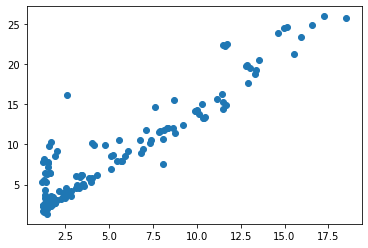

In [149]:
# for i in range(90):
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
def plot_fn(xpoints=None, ypoints=None):
    ax.scatter(xpoints, ypoints)
    plt.show()
plot_fn([xy[0] for xy in items_dict[i]], [xy[1] for xy in items_dict[i]])

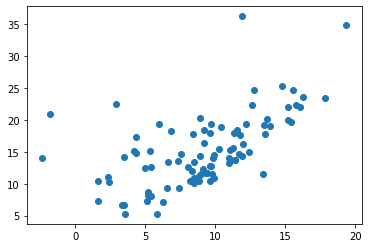

In [215]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
def plot_fn(xpoints=None, ypoints=None):
    ax.scatter(xpoints, ypoints)
    plt.show()
plot_fn([xy[0] for xy in centers], [xy[1] for xy in centers])

In [203]:
sum(items_dict[1])/len(items_dict[1])

array([1.25354161, 2.27796607])

In [219]:
def scdv_artm(item, centers):
    soft = list()
    for s in range(90):
        soft.append(1/(distance.euclidean(item[2*s:2*(s+1)], centers[s]) ** 2))
    return np.array(soft)/sum(soft)

In [41]:
sorted(zip(range(90), test_vectores[8]), key = lambda x: x[1], reverse = True)[0]

(89, 0.23342948642517786)

In [237]:
length = len(soft_clustersKD_ARTM_new['регрессия'])

for elem in tqdm(test_data[110*0:110*(0+1)]):
    sum_ = np.array([0]*length)
    counter = 0
    for word in elem.split():
        try:
            sum_ = sum_ + np.array(soft_clustersKD_ARTM_new[word])
            counter = counter + 1
        except:
            pass
    if counter != 0:
        test_vectores.append(sum_/counter)

100%|███████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 150.25it/s]


In [241]:
len(test_vectores[0])

90

# Test

In [25]:
os.chdir(path_to_prog + 'For_test_new')
test_data = list()
texts_1 = list()
texts_2 = list()
i = 0
for item in sorted(os.listdir(), key = lambda x: int(x.split(sep = '.')[0])):
    with open(item, 'r+', encoding='utf-8') as file:
        texts_1.append(file.read())

def_dict1 = defaultdict(str)
for i in tqdm(range(len(texts_1))):
    def_dict1[i] += texts_1[i]

for text in tqdm(texts_1):
    test_data.append(clean_data(text))

100%|████████████████████████████████████████████████████████████████████████████████| 550/550 [09:25<00:00,  1.03s/it]


In [75]:
with open(r'C:\Users\vdtri\Documents\ВКР\Программа\models\SCDV\sen_1', 'rb') as f:
    sentences_1 = pickle.load(f)

In [14]:
test_data = sentences_1[-550:]
len(test_data)

550

# SCDV

In [24]:
big_res = list()
for s in range(3):
    test_vectores = scdv.get_vectors(test_data[110*s:110*(s+1)])

    results = list()
    for i in [i*11 for i in range(10)]:
        results.append(dist_top10(test_vectores[i], test_vectores))

    leest = list()
    for i in range(10):
        leest.append(prec(list(map(lambda x: x[0], results[i])), 10, i*11))
    big_res.append(sum(leest)/len(leest))
#    print(sum(leest)/len(leest))
print(sum(big_res)/ len(big_res))

0.7433333333333333


In [22]:
sum(test_vectores[0])

1.0

# ARTM

In [43]:
theta_list_test = list()
for i in tqdm(test_data):
    theta_list_test.append(get_theta(model_artm, doc2vow(i)))

100%|████████████████████████████████████████████████████████████████████████████████| 550/550 [07:59<00:00,  1.15it/s]


In [44]:
big_res = list()
for s in range(3):
    test_vectores = list()
    elem = theta_list_test[110*s:110*(s+1)]

    results = list()
    for i in [i*11 for i in range(10)]:
        results.append(dist_top10(elem[i], elem))

    leest = list()
    for i in range(10):
        leest.append(prec(list(map(lambda x: x[0], results[i])), 10, i*11))
    big_res.append(sum(leest)/len(leest))
print(sum(big_res)/ len(big_res))

0.79


without noise

In [45]:
theta_list_test = list()
for i in tqdm(test_data):
    theta_list_test.append(get_theta(model_artm_noise, doc2vow(i)))

100%|████████████████████████████████████████████████████████████████████████████████| 550/550 [07:52<00:00,  1.16it/s]


In [46]:
big_res = list()
for s in range(5):
    test_vectores = list()
    elem = theta_list_test[110*s:110*(s+1)]

    results = list()
    for i in [i*11 for i in range(10)]:
        results.append(dist_top10(elem[i], elem))

    leest = list()
    for i in range(10):
        leest.append(prec(list(map(lambda x: x[0], results[i])), 10, i*11))
    big_res.append(sum(leest)/len(leest))
print(sum(big_res)/ len(big_res))

0.7659999999999999


# Top2vec

In [45]:
test_vecs = list()
model.add_documents(test_data)
test_vecs = model._get_document_vectors()[-550:]

In [50]:
topic_vectors = model.topic_vectors
doc_vectors = model._get_document_vectors()[-550:]
print(len(topic_vectors[0]))
new_test_vecs = list()
for ind, item in tqdm(enumerate(doc_vectors)):
    new_test_vecs.append(topic_probs(doc_vectors[ind], topic_vectors, 2))

15it [00:00, 136.61it/s]

300


550it [00:01, 349.81it/s]


In [51]:
big_res = list()
for s in range(3):
    test_vectores = list()
    elem = new_test_vecs[110*s:110*(s+1)]

    results = list()
    for i in [i*11 for i in range(10)]:
        results.append(dist_top10(elem[i], elem))

    leest = list()
    for i in range(10):
        leest.append(prec(list(map(lambda x: x[0], results[i])), 10, i*11))
    big_res.append(sum(leest)/len(leest))
print(sum(big_res)/ len(big_res))

0.79


Without noise

In [22]:
test_vecs = list()
model_noise.add_documents(test_data)
test_vecs = model_noise._get_document_vectors()[-550:]

In [23]:
topic_vectors = model_noise.topic_vectors
doc_vectors = model_noise._get_document_vectors()[-550:]
print(len(topic_vectors[0]))
new_test_vecs = list()
for ind, item in tqdm(enumerate(doc_vectors)):
    new_test_vecs.append(topic_probs(doc_vectors[ind], topic_vectors, 2))

26it [00:00, 250.17it/s]

300


550it [00:01, 317.76it/s]


In [24]:
big_res = list()
for s in range(3):
    test_vectores = list()
    elem = new_test_vecs[110*s:110*(s+1)]

    results = list()
    for i in [i*11 for i in range(10)]:
        results.append(dist_top10(elem[i], elem))

    leest = list()
    for i in range(10):
        leest.append(prec(list(map(lambda x: x[0], results[i])), 10, i*11))
    big_res.append(sum(leest)/len(leest))
print(sum(big_res)/ len(big_res))

0.7833333333333332


# SCDV with ARTM

In [78]:
big_res = list()
for s in range(3):
    test_vectores = list()
    length = len(soft_clustersKD_ARTM_new['регрессия'])
    for elem in test_data[110*s:110*(s+1)]:
        sum_ = np.array([0]*length)
        counter = 0
        for word in elem.split():
            try:
                sum_ = sum_ + np.array(soft_clustersKD_ARTM_new[word])
                counter = counter + 1
            except:
                pass
        test_vectores.append(sum_/counter)
        
    for ind, elem in enumerate(test_vectores):
        test_vectores[ind] = elem/sum(elem)
    results = list()
    for i in [i*11 for i in range(10)]:
        results.append(dist_top10(test_vectores[i], test_vectores))
    leest = list()
    for i in range(10):
        leest.append(prec(list(map(lambda x: x[0], results[i])), 10, i*11))
    big_res.append(sum(leest)/len(leest))
print(sum(big_res)/ len(big_res))

0.8333333333333334


In [122]:
len(soft_clustersKD_ARTM['регрессия'])

1350

In [21]:
data = list()
for text in sentences_1:
    if len(text.split())<5000:
        data.append(len(text.split()))

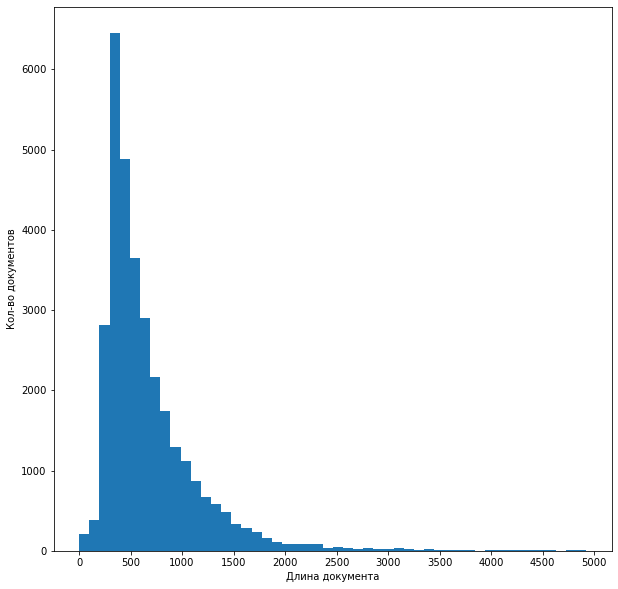

In [26]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.xticks(np.arange(0, 10000, 500))

plt.hist(data, bins=50)  # density=False would make counts
plt.ylabel('Кол-во документов')
plt.xlabel('Длина документа');

<BarContainer object of 4 artists>

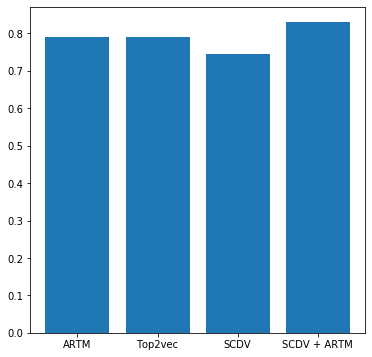

In [79]:
groups = ["ARTM", "Top2vec", "SCDV", "SCDV + ARTM"]
counts = [0.79, 0.79, 0.745, 0.83]
plt.figure(figsize=(6, 6))
plt.bar(groups, counts)

<BarContainer object of 3 artists>

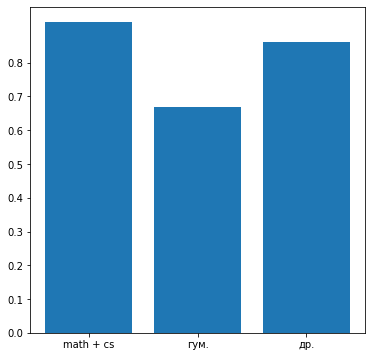

In [133]:
groups = ["math + cs", "гум.", "др."]
counts = [0.92, 0.67, 0.86]
plt.figure(figsize=(6, 6))
plt.yticks(np.arange(0, 0.9, 0.1))
plt.bar(groups, counts)

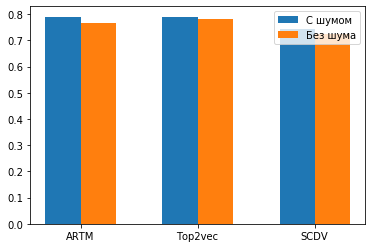

In [107]:
cat_par = ["ARTM", "Top2vec", "SCDV"]
g1 = [0.79, 0.79, 0.745]
g2 = [0.765, 0.783, 0.725]
width = 0.3
x = np.arange(len(cat_par))

fig, ax = plt.subplots()
ax.set_yticks(np.arange(0, 1, 0.1))
rects1 = ax.bar(x - width/2, g1, width, label='С шумом')
rects2 = ax.bar(x + width/2, g2, width, label='Без шума')
ax.set_xticks(x)
ax.set_xticklabels(cat_par)
ax.legend()

In [131]:
test_vectores = list()
length = len(soft_clustersKD_ARTM_new['регрессия'])
for elem in test_data[110*2:110*(2+1)]:
    sum_ = np.array([0]*length)
    counter = 0
    for word in elem.split():
        try:
            sum_ = sum_ + np.array(soft_clustersKD_ARTM_new[word])
            counter = counter + 1
        except:
            pass
    test_vectores.append(sum_/counter)

for ind, elem in enumerate(test_vectores):
    test_vectores[ind] = elem/sum(elem)
results = list()
for i in [i*11 for i in range(10)]:
    results.append(dist_top10(test_vectores[i], test_vectores))
    
leest = list()
for i in range(10):
    leest.append(prec(list(map(lambda x: x[0], results[i])), 10, i*11))

In [130]:
leest

[1.0, 1.0, 0.9, 1.0, 0.9, 0.8, 1.0, 1.0, 1.0, 0.9]

In [124]:
results[0]

[(3, 0.10953356570675676),
 (5, 0.11873308595437826),
 (7, 0.15077819595760367),
 (2, 0.2852403098688534),
 (6, 0.37847128632793225),
 (4, 0.6020588696697629),
 (9, 0.6144910263595542),
 (8, 0.6615262847841696),
 (1, 0.6913443467696925),
 (50, 0.7089510997777836)]

In [112]:
print(texts_1[11*9])

Рито́рика ( др.-греч. ἡ ῥητορικὴ τέχνη «ораторское искусство» ← ῥήτωρ « оратор ») — филологическая дисциплина, изучающая искусство речи , правила построения художественной речи, ораторское искусство, мировоззрение и красноречие [1] [2] . Первоначальное значение слова риторика — наука об ораторском искусстве — впоследствии расширилось до теории прозы, аргументации . Европейская риторика началась в Древней Греции, в школах софистов , практиковавших обучение красноречию и собиравших стилистические и грамматические правила. Риторика развивалась под влиянием Аристотеля [3] , Цицерона и Квинтилиана . Расцвет христианского красноречия относится к IV−V векам. Западное красноречие было особенно сильным в Италии ( Бембо и Кастильоне ; XVI век), где, благодаря противостоянию латинского (научного) и итальянского (народного) языков получило развитие учение о трёх стилях . В России до Петра I существовало исключительно духовное красноречие [4] , которое преподавали в юго-западных духовных школах с X

In [114]:
print(texts_1[75])

' Литература ( лат. lit(t)eratura , — написанное , от lit(t)era — буква) — в широком смысле слова совокупность любых письменных текстов . Чаще всего под литературой понимают художественную литературу , то есть литературу как вид искусства . Однако это понимание, сложившееся в эпоху романтизма , не следует прямо применять к культуре отдалённых от сегодняшнего дня эпох. Древние научные трактаты и религиозно - мифологические сочинения — такие, например, как « Теогония » Гесиода или « О природе вещей » Лукреция — с точки зрения современников не противопоставлялись, например, эпическим поэмам (« Илиаде » Гомера или « Энеиде » Вергилия ) как нехудожественная литература художественной. В России ещё в 1820-е годы критики сходились во мнении, что лучшие образцы русской прозы — « История Государства Российского » Карамзина и « Опыт теории налогов » Николая Тургенева [1] . Отделяя художественную литературу других периодов от литературы религиозной, философской, научной, публицистической, мы проец